In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='6'
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'

In [78]:
import albumentations as A
from albumentations.core.bbox_utils import normalize_bboxes

import json
import shutil
from tqdm.notebook import tqdm
import yaml
import numpy as np
import glob, gc
import cv2

import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pycocotools.mask as mask_util
from pycocotools import _mask as coco_mask

import ultralytics
from ultralytics import YOLO, SAM
from ultralytics.yolo.utils.ops import scale_boxes, scale_coords, scale_image, non_max_suppression
from ultralytics.nn.tasks import attempt_load_weights
from ultralytics.yolo.v8.segment import SegmentationPredictor
from ultralytics.yolo.utils import IterableSimpleNamespace, DEFAULT_CFG_KEYS, DEFAULT_CFG_DICT, DEFAULT_CFG
from copy import deepcopy
ultralytics.checks()


Ultralytics YOLOv8.0.131 🚀 Python-3.9.16 torch-2.0.0 CUDA:0 (NVIDIA A100 80GB PCIe, 81251MiB)
Setup complete ✅ (64 CPUs, 376.5 GB RAM, 781.8/915.6 GB disk)


In [3]:
def set_seed(seed=42):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

In [29]:
from dataclasses import dataclass

@dataclass
class CFG:
    dilation_n_iter: int = 0
    conf: float = 0.01
    imgsz: int = (512, 512)
    retina_masks: bool = True
    iou_nms: float = 0.7
    iou_nms_tta: float = 0.7
    author: str = 'tg @ai_minds'
    sam_model: str = 'sam_l.pt'
    transforms = [None]
#     transforms = [None, A.HorizontalFlip(p=1.0)]
    
#     transforms = [None, A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0), A.Rotate(limit=(180,180), p=1.0)]
    models = [
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold0.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold1.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold2.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold3.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold4.pt',
        
    ]

    def __repr__(self):
        return f"CFG({', '.join(f'{k}={v}' for k, v in self.__dict__.items())})"

In [5]:
BASE_FILENAME = 'folds/'
# BASE_FILENAME = '/kaggle/input/hubmap-hacking-the-human-vasculature'

In [6]:
# model1 = YOLO('HuBMAP/yolov8x-seg-fold0/weights/best.pt')
# model2 = YOLO('HuBMAP/yolov8x-seg-fold1/weights/best.pt')

In [7]:
# !pip install --no-index \
# /kaggle/input/wbf-download-code-for-offline-installation/Weighted-Boxes-Fusion/ensemble_boxes-1.0.7-py3-none-any.whl \
# --find-links=/kaggle/input/wbf-download-code-for-offline-installation/Weighted-Boxes-Fusion

In [8]:
# !pip install ensemble-boxes

In [9]:
from skimage import draw

def make_negative_mask(annotations, size=(512, 512)):
    mask = np.zeros(size, dtype=np.float32)
    for annot in annotations:
        cords = annot['coordinates']
        if annot['type'] == "glomerulus":
            for cord in cords:
                rr, cc = np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord])
                rr, cc = draw.polygon(rr, cc)
                mask[rr, cc] = 1
    return mask

In [10]:
from skimage import draw

def make_masks(annotations, size=(512, 512)):
    masks = []
    for annot in annotations:
        mask = np.zeros(size, dtype=np.float32)
        cords = annot['coordinates']
        if annot['type'] == "blood_vessel":
            for cord in cords:
                rr, cc = np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord])
                rr, cc = draw.polygon(rr, cc)
                mask[rr, cc] = 1
            masks.append(mask)
    if len(masks) == 0:
        masks.append(np.zeros(size, dtype=np.float32))
    return np.stack(masks)

In [11]:
# %%writefile ensemble_boxes_nms.py
# # coding: utf-8


In [12]:
# del nms
from ensemble_boxes_nms import nms

In [162]:
import networkx as nx

def get_iou_matrix_from_boxes(bounding_boxes1, bounding_boxes2):

    """
    Calculate IoU matrix between two sets of bounding boxes

    Parameters
    ----------
    bounding_boxes1 [numpy.ndarray of shape (n_objects, 4)]: Bounding boxes
    bounding_boxes2 [numpy.ndarray of shape (m_objects, 4)]: Bounding boxes

    Returns
    -------
    iou_matrix [numpy.ndarray of shape (n_objects, m_objects)]: IoU matrix between two sets of bounding boxes
    """

    bounding_boxes1_x1, bounding_boxes1_y1, bounding_boxes1_x2, bounding_boxes1_y2 = np.split(bounding_boxes1, 4, axis=1)
    bounding_boxes2_x1, bounding_boxes2_y1, bounding_boxes2_x2, bounding_boxes2_y2 = np.split(bounding_boxes2, 4, axis=1)

    xa = np.maximum(bounding_boxes1_x1, np.transpose(bounding_boxes2_x1))
    ya = np.maximum(bounding_boxes1_y1, np.transpose(bounding_boxes2_y1))
    xb = np.minimum(bounding_boxes1_x2, np.transpose(bounding_boxes2_x2))
    yb = np.minimum(bounding_boxes1_y2, np.transpose(bounding_boxes2_y2))

    inter_area = np.maximum((xb - xa + 1), 0) * np.maximum((yb - ya + 1), 0)
    box_a_area = (bounding_boxes1_x2 - bounding_boxes1_x1 + 1) * (bounding_boxes1_y2 - bounding_boxes1_y1 + 1)
    box_b_area = (bounding_boxes2_x2 - bounding_boxes2_x1 + 1) * (bounding_boxes2_y2 - bounding_boxes2_y1 + 1)
    iou_matrix = inter_area / (box_a_area + np.transpose(box_b_area) - inter_area)

    return iou_matrix


def get_iou_matrix_from_masks(masks1, masks2):

    """
    Calculate IOU matrix between two sets of masks

    Parameters
    ----------
    masks1 [numpy.ndarray of shape (n_objects, height, width)]: 2d binary masks
    masks2 [numpy.ndarray of shape (m_objects, height, width)]: 2d binary masks

    Returns
    -------
    iou_matrix [numpy.ndarray of shape (n_objects, m_objects)]: IoU matrix between two sets of masks
    """

    if len(list(masks1)) == 0 or len(list(masks2)) == 0:
        print(f'empty predictions - masks1 len {len(list(masks1))}, masks2 len {len(list(masks2))}')
        return np.array([[]])

    enc_masks1 = [mask_util.encode(np.asarray(p, order='F')) for p in (masks1 > 0.5).astype(np.uint8)]
    enc_masks2 = [mask_util.encode(np.asarray(p, order='F')) for p in (masks2 > 0.5).astype(np.uint8)]
    iou_matrix = mask_util.iou(enc_masks1, enc_masks2, [0] * len(enc_masks1))

    return iou_matrix


def blend_masks(prediction_boxes, prediction_masks, prediction_scores, iou_threshold=0.9, label_threshold=0.5, iou_method='boxes', drop_single_components=True):

    """
    Blend prediction masks of multiple models based on IoU and returns average scores of blended masks

    Parameters
    ----------
    prediction_boxes [list of shape (n_models)]: Bounding box predictions of multiple models
    prediction_masks [list of shape (n_models)]: Mask predictions of multiple models
    prediction_scores [list of shape (n_models)]: Score predictions of multiple models
    iou_threshold (int): IoU threshold for blending masks (0 <= iou_threshold <= 1)
    iou_method (str): boxes or masks
    label_threshold (int): Label threshold for converting soft predictions to labels (0 <= iou_threshold <= 1)
    drop_single_components (bool): Whether to discard predictions without connections or not

    Returns
    -------
    blended_masks [numpy.ndarray of shape (n_objects, height, width)]: Blended binary masks
    average_scores [list of floats]: Average scores of blended masks
    """

    iou_matrices = {}

    # Create all combinations of IoU matrices from given predictions
    for i in range(len(prediction_masks)):
        for j in range(i, len(prediction_masks)):
            if i == j:
                continue

            if iou_method == 'boxes':
                iou_matrix = get_iou_matrix_from_boxes(prediction_boxes[i], prediction_boxes[j])
            elif iou_method == 'masks':
                iou_matrix = get_iou_matrix_from_masks(prediction_masks[i], prediction_masks[j])

            iou_matrices[f'{i + 1}_{j + 1}'] = iou_matrix

    # Create a graph to store connected bounding boxes
    bounding_box_graph = nx.Graph()

    # Add all masks from all models as nodes
    for model_idx, boxes in enumerate(prediction_masks, start=1):
        nodes = [f'model{model_idx}_box{box_idx}' for box_idx in np.arange(len(boxes))]
        bounding_box_graph.add_nodes_from(nodes)

    del prediction_boxes

    # Add edges between nodes with IoU >= iou_threshold
    for model_combination, iou_matrix in iou_matrices.items():
        matching_boxes_idx = np.where(iou_matrix >= iou_threshold)
        model1_idx, model2_idx = model_combination.split('_')
        edges = [(f'model{model1_idx}_box{box1}', f'model{model2_idx}_box{box2}') for box1, box2 in zip(*matching_boxes_idx)]
        bounding_box_graph.add_edges_from(edges)

    del iou_matrices
    blended_masks = []
    blended_scores = []  # List to store average scores

    for connections in nx.connected_components(bounding_box_graph):
        if len(connections) == 1:
            # Skip mask if its bounding isn't connected to any other bounding box
            if drop_single_components:
                continue
            else:
                # Append mask directly if its bounding box isn't connected to any other bounding box
                model_idx, box_idx = list(connections)[0].split('_')
                model_idx = int(model_idx.replace('model', ''))
                box_idx = int(box_idx.replace('box', ''))
                blended_masks.append(prediction_masks[model_idx - 1][box_idx])
                blended_scores.append(prediction_scores[model_idx - 1][box_idx])  # Append the score
        else:
            # Blend mask with its connections and append
            blended_mask = np.zeros((512, 512), dtype=np.float32)
            total_score = 0  # Total score for normalization
            scores = []  # Scores of the boxes in this connection
            for connection in connections:
                model_idx, box_idx = connection.split('_')
                model_idx = int(model_idx.replace('model', ''))
                box_idx = int(box_idx.replace('box', ''))
                score = prediction_scores[model_idx - 1][box_idx]  # Score for this box
                total_score += score  # Update total score
                scores.append(score)  # Append the score
                # Multiply mask prediction with score and accumulate on blended_mask
                blended_mask += (prediction_masks[model_idx - 1][box_idx] * score)
            # Normalize blended_mask by total score
            blended_mask /= total_score
            blended_masks.append(blended_mask)
            blended_scores.append(sum(scores) / len(scores))  # Append the average score

    del prediction_masks, bounding_box_graph
    if len(blended_masks) == 0:
        return np.zeros((1, 512, 512)), [0]
    blended_masks = np.stack(blended_masks)
    # Convert soft predictions to binary labels
    blended_masks = np.uint8(blended_masks >= label_threshold)

    return blended_masks, np.array(blended_scores)

In [163]:
def predict(image, models, transforms=[None], imgsz=512, conf=0.01, iou_nms=0.5, retina_masks=True, iou_nms_tta=0.7, blend=True):
    masks, scores, boxes = [], [], []
    
    og_img = np.array(image.copy()).astype(np.uint8)[...,::-1]
    h, w = og_img.shape[:2]
    
    for model in models:
        for transform in transforms:
            if transform is not None:
                img = transform(image=og_img)['image']
            else:
                img = og_img.copy()
            
            pred = model.predict(img, imgsz=imgsz, conf=conf, iou=iou_nms, retina_masks=retina_masks, verbose=False)[0]
            
            if pred.masks is None:
                continue
            
            pred_masks = pred.masks.data[pred.boxes.cls == 0].detach().cpu().numpy()
            
            if len(pred_masks) == 0:
                continue
            
            
            pred_confs = pred.boxes.conf[pred.boxes.cls == 0].detach().cpu().numpy()
            pred_boxes = pred.boxes.data[pred.boxes.cls == 0].detach().cpu().numpy()
            pred_boxes = A.core.bbox_utils.normalize_bboxes(pred_boxes, h, w)
            
            if transform is not None:
                # optim here
                pred_boxes = transform(image=img, bboxes=pred_boxes)['bboxes']
                pred_masks = transform(image=img, masks=pred_masks)['masks']
                
            boxes.append(np.array(pred_boxes))
            scores.append(np.array(pred_confs))
            masks.append(pred_masks)
            del pred, pred_boxes, pred_masks, img
    del og_img
    

    if len(boxes) == 0:
        return np.zeros((1, h, w), np.uint8), [0]
    if not blend:
        boxes = np.concatenate(boxes)
        scores = np.concatenate(scores)
        masks = np.concatenate(masks)
        nms_boxes, nms_scores = nms(
                                    [boxes],
                                    [scores],
                                    iou_thr=iou_nms_tta
                                   )

        nms_masks = []
        scores_list = scores.tolist()
        for s in nms_scores:
            nms_masks.append(masks[scores_list.index(s)])
        nms_masks = np.stack(nms_masks).astype(bool)
        nms_scores = np.array(nms_scores)
    
        return nms_masks, nms_scores
    else:
        boxes = [box[:, :4] for box in boxes]
        blended_masks, blended_scores = blend_masks(boxes, masks, scores, iou_threshold=0.7, drop_single_components=False)
        return blended_masks, blended_scores
    

In [14]:
def parse_ann(annotations):
    target = []
    for annot in annotations:
        if annot['type'] == "blood_vessel":
            target.append(np.array(annot['coordinates']).flatten().tolist())
    return target

# Utils

In [15]:
from skimage.morphology import binary_dilation, binary_closing, binary_opening
from skimage.measure import label, regionprops

def join_masks(masks: np.ndarray):
    """masks in shape n x W x H """
    return np.any(masks, axis=0).astype(int)

def substact_masks(mask1, mask2):
    substraction = mask1 & ~mask2
    if len(substraction) == 0:
        return np.zeros_like(mask1)
    return substraction

def disjoin_mask(mask):
    """mask in shape W x H"""
    if not np.any(mask):
        return mask[None, :, :]
    labeled_mask = label(mask)  # Результат - маска, где каждый объект имеет уникальное число
    props = regionprops(labeled_mask)

    new_masks = []
    for prop in props:
        new_mask = np.zeros_like(mask)
        new_mask[labeled_mask == prop.label] = 1
        new_masks.append(new_mask)

    new_masks_array = np.array(new_masks)
    return new_masks_array

def dilate_predict_mask(mask, n_iter=1):
    for i in range(len(mask)):
        for _ in range(n_iter):
            mask[i] = binary_dilation(mask[i])
    return mask

# Metrics

In [16]:
from metrics import MAPCalculatorSingleClass

# Training

In [17]:
with open('../data/polygons.jsonl', 'r') as json_file:
    json_labels = [json.loads(line) for line in json_file]

id_to_annotation = {j['id']: j['annotations'] for j in json_labels}

In [20]:
DATA_BASE = 'dataset'
BASE_FILENAME = '../data/'

In [21]:
def evaluate_model(annotations, prediction_masks, predicition_scores):
    mAP_calc = MAPCalculatorSingleClass()
    height, width = (512, 512)
    ious = [] 
    for ann, pred_masks, scores in zip(annotations, prediction_masks, predicition_scores):
        if len(ann) == 0:
            continue
        enc_gt = coco_mask.frPyObjects(ann, height, width)
        num_gts = len(enc_gt)
        enc_pred = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
        
        _ious = mask_util.iou(enc_pred, enc_gt, [0]*len(enc_gt))
        mAP_calc.accumulate(_ious, scores, num_gts)
        score = mAP_calc.evaluate()[0]
        ious.append(score)
    return ious

In [22]:
FOLDS_ROOT = 'folds/'
# FOLDS_ROOT = '/kaggle/input/hubmap-folds/

PROJECT = 'HuBMAP'

MODEL_V = 'yolov8x-seg'

In [28]:
# image = Image.open('test.tif')
image = Image.open('../data/train/0006ff2aa7cd.tif')

In [25]:
model = YOLO('../checkpoints/yolov8x-seg-fold0.pt')

In [79]:
models = [
    YOLO(f'../checkpoints/yolov8x-seg-fold{i}.pt') for i in range(5)
]

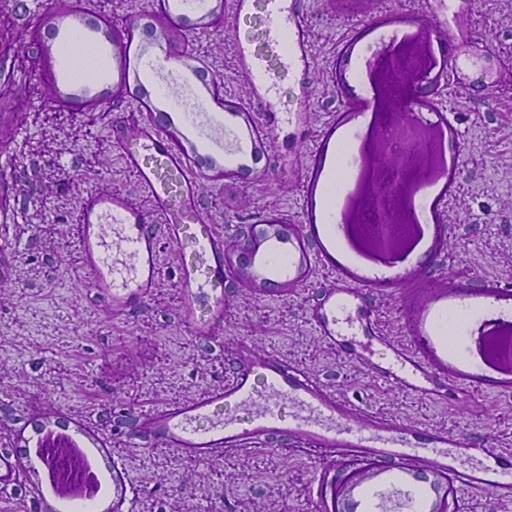

In [80]:
image

In [90]:
_, masks, scores = predict(image, models)

In [94]:
boxes1, masks1, scores = predict(image, [models[0]])
boxes2, masks2, scores = predict(image, [models[1]])

In [97]:
boxes1[:, :4].shape

(29, 4)

In [100]:
blended = blend_masks([boxes1[:, :4], boxes2[:, :4]], [masks1, masks2])

In [101]:
blended.shape

(18, 512, 512)

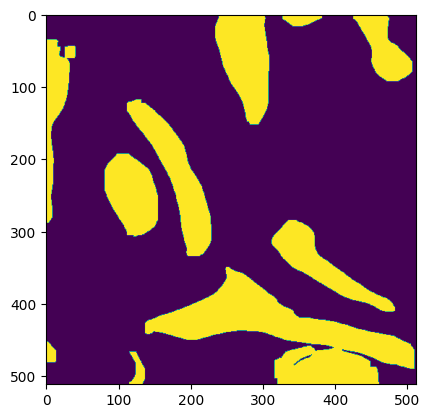

In [102]:
plt.imshow(np.any(blended, 0))

In [165]:
from dataclasses import dataclass

@dataclass
class CFG:
    dilation_n_iter: int = 0
    conf: float = 0.01
    imgsz: int = (512, 512)
    retina_masks: bool = True
    iou_nms: float = 0.3
    iou_nms_tta: float = 0.3
    author: str = 'tg @ai_minds'
    sam_model: str = 'sam_l.pt'
#     transforms = [None]
    transforms = [None, A.HorizontalFlip(p=1.0)]
    
#     transforms = [None, A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0), A.Rotate(limit=(180,180), p=1.0)]
    models = [
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold0.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold1.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold2.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold3.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold4.pt',
        
    ]

    def __repr__(self):
        return f"CFG({', '.join(f'{k}={v}' for k, v in self.__dict__.items())})"

In [166]:
# folds_i = [0, 1, 2, 3, 4]
folds_i = [0, 1, 2, 3, 4]
# folds_i = [0]



folds_iou = dict()
for i in folds_i:
    path_to_data = f'{FOLDS_ROOT}/fold{i}/hubmap-coco.yaml'

    
    model = YOLO(f'{PROJECT}/{MODEL_V}-fold{i}/weights/best.pt')
    
    
    val_dir = f'{FOLDS_ROOT}/fold{i}/valid/'
    val_ids = [r.split('.')[0] for r in os.listdir(val_dir) if r.endswith('.txt')]
    
    annotations = []
    pred_masks = []
    pred_scores = []
    for image_id in val_ids:
        annotations.append(parse_ann(id_to_annotation[image_id]))
        image = Image.open(os.path.join(val_dir ,image_id+'.tif'))
#         negative_mask = make_negative_mask(id_to_annotation[image_id], size=image.size)
        
        masks, scores = predict(image=image,
                                models=[model],
                                transforms=CFG.transforms,
                                imgsz=CFG.imgsz,
                                conf=CFG.conf,
                                iou_nms=CFG.iou_nms,
                                retina_masks=CFG.retina_masks,
                                blend=True,
                               )
        keep = []
        for j, (score, mask) in enumerate(zip(scores, masks)):
            keep.append(j)

            
        masks = dilate_predict_mask(masks, CFG.dilation_n_iter)
        pred_masks.append(masks[keep])
        pred_scores.append(scores[keep])
    
    ious = evaluate_model(annotations, pred_masks, pred_scores)
    print(f'fold {i} IOU mean: {np.mean(ious)}')
    print(f'fold {i} IOU std: {np.std(ious)}')
    print()
    
    folds_iou[i] = ious

fold 0 IOU mean: 0.21556907649799986
fold 0 IOU std: 0.029265475629151178



KeyboardInterrupt: 

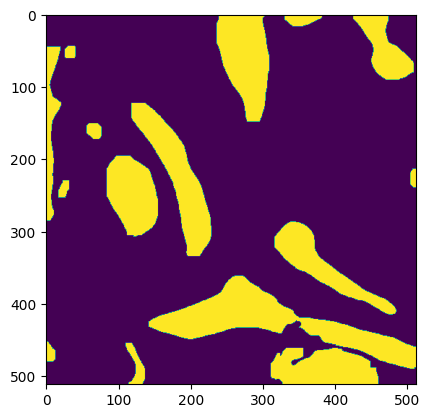

In [92]:
plt.imshow(np.any(masks, 0))

In [ ]:
# no dilation with no tta

In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.3, iou_nms_tta=0.3, author=tg @ai_minds, sam_model=sam_l.pt)
# fold 0 IOU mean: 0.5810630028728818
# fold 0 IOU std: 0.01242938740762414
# fold 1 IOU mean: 0.5862236411273175
# fold 1 IOU std: 0.022572651887895537
# fold 2 IOU mean: 0.577123098152969
# fold 2 IOU std: 0.021627394262583248
# fold 3 IOU mean: 0.5526609675078908
# fold 3 IOU std: 0.03596290372500657
# fold 4 IOU mean: 0.5772421264235482
# fold 4 IOU std: 0.02602384296638565

In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.3, iou_nms_tta=0.3, author=tg @ai_minds, sam_model=sam_l.pt)
# fold 0 IOU mean: 0.5810630028728818
# fold 0 IOU std: 0.01242938740762414
# fold 1 IOU mean: 0.5862236411273175
# fold 1 IOU std: 0.022572651887895537
# fold 2 IOU mean: 0.577123098152969
# fold 2 IOU std: 0.021627394262583248
# fold 3 IOU mean: 0.5526609675078908
# fold 3 IOU std: 0.03596290372500657
# fold 4 IOU mean: 0.5772421264235482
# fold 4 IOU std: 0.02602384296638565

In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.7, author=tg @ai_minds)
# fold 0
# IOU mean: 0.5813883380571195
# IOU std: 0.021602333573493074
# fold 1
# IOU mean: 0.5718512034934188
# IOU std: 0.021204994571685447
# fold 2
# IOU mean: 0.577511672296694
# IOU std: 0.01872297097533825
# fold 3
# IOU mean: 0.5571941140070192
# IOU std: 0.03718892123463371
# fold 4
# IOU mean: 0.5767471303179905
# IOU std: 0.031885737575472674

In [24]:
i = 0
path_to_data = f'{FOLDS_ROOT}/fold{i}/hubmap-coco.yaml'


model = YOLO(f'{PROJECT}/{MODEL_V}-fold{i}/weights/best.pt')


val_dir = f'{FOLDS_ROOT}/fold{i}/valid/'
val_ids = [r.split('.')[0] for r in os.listdir(val_dir) if r.endswith('.txt')]
annotations = [parse_ann(ANN_DICT[image_id]) for image_id in val_ids]
images = [Image.open(os.path.join(val_dir ,image_id+'.tif')) for image_id in val_ids]

In [26]:
tile_meta = pd.read_csv("../data/tile_meta.csv")

In [27]:
tile_meta

id  source_wsi  dataset      i      j
0     0006ff2aa7cd           2        2  16896  16420
1     000e79e206b7           6        3  10240  29184
2     00168d1b7522           2        2  14848  14884
3     00176a88fdb0           7        3  14848  25088
4     0033bbc76b6b           1        1  10240  43008
...            ...         ...      ...    ...    ...
7028  ffd37b5c6598          13        3  13824  21504
7029  ffd3d193c71e           3        2   7680  16896
7030  ffd77e2517af          13        3  15872  28160
7031  ffe3cbb81f72          10        3  15456  23000
7032  ffe40e3bc324           9        3  13824  19456

[7033 rows x 5 columns]

In [160]:
def create_tile_mosaic(image_id, image_dir, df):
    
    source_wsi = df[df['id'] == image_id]['source_wsi'].values[0]
    image = cv2.cvtColor(cv2.imread(os.path.join(image_dir, image_id+'.tif')), cv2.COLOR_BGRA2RGB)
    h, w, _ = image.shape
    assert h == w
    image_dim = h
    mosaic = np.zeros((image_dim*3, image_dim*3, 3), np.uint8)
    
    image_coordinates = df[df['id'] == image_id][['i', 'j']].values[0]
    
    coordinates = [
           (image_coordinates[0]+image_dim, image_coordinates[1]),  # Top left
           (image_coordinates[0]+image_dim, image_coordinates[1]-image_dim),  # Top center
           (image_coordinates[0], image_coordinates[1]-image_dim),  # Top right
           (image_coordinates[0]-image_dim, image_coordinates[1]),  # Center right
           (image_coordinates[0]-image_dim, image_coordinates[1]+image_dim),  # Bottom right
           (image_coordinates[0], image_coordinates[1]+image_dim),  # Bottom center
           (image_coordinates[0]+image_dim, image_coordinates[1]+image_dim),  # Bottom left
           (image_coordinates[0], image_coordinates[1]), # Center left
    ]



    
    # Put the image in the center of the mosaic
    mosaic[image_dim:image_dim*2, image_dim:image_dim*2, :] = image
    
    # Loop over each coordinate and if image exists replace the corresponding part of the mosaic
    for i, coord in enumerate(coordinates):
        surrounding_image_id = df[(df['i'] == coord[0]) & (df['j'] == coord[1]) & (df['source_wsi'] == source_wsi)]['id']
        if len(surrounding_image_id) > 0:
            surrounding_image = cv2.cvtColor(cv2.imread(os.path.join(image_dir, surrounding_image_id.values[0]+'.tif')), cv2.COLOR_BGRA2RGB)
            
            row = (i // 3) * image_dim
            col = (i % 3) * image_dim
            row, col = col, row
            mosaic[row:row+image_dim, col:col+image_dim, :] = surrounding_image
    
    return mosaic

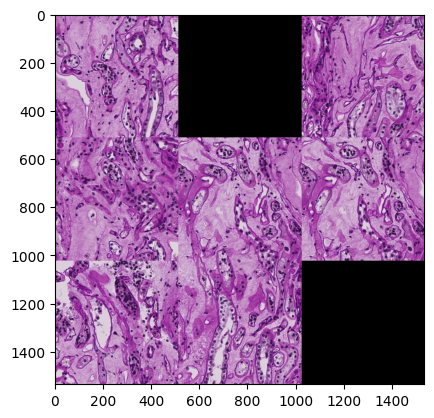

In [161]:
mosaic = create_tile_mosaic(val_ids[1], '../data/train/', tile_meta)
plt.imshow(mosaic)

In [76]:
df = tile_meta.copy()

In [151]:
coo[0]

4608

In [152]:
sur = df[(df['i'] == coo[0]) & (df['j'] == coo[1]) & (df['source_wsi'] != 9)]

In [153]:
sur

id  source_wsi  dataset     i      j
6151  dee28705d563           4        2  4608  25088

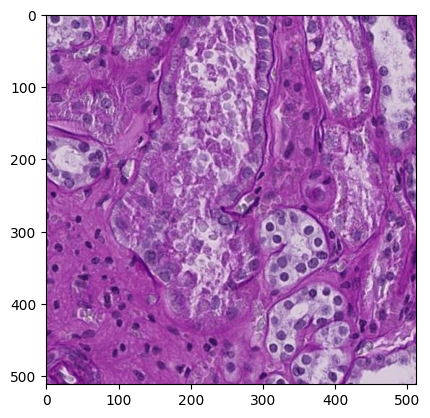

In [154]:
plt.imshow(image)

In [162]:
mosaic = np.zeros((image_dim*3, image_dim*3, 3), np.uint8)

In [163]:
mosaic[image_dim:image_dim*2, image_dim:image_dim*2, :] = image

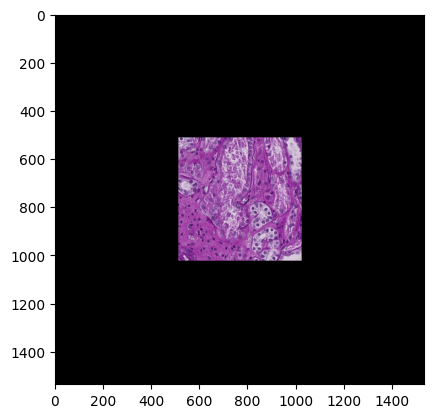

In [164]:
plt.imshow(mosaic)

In [165]:
surrounding_image_id = sur['id'].values[0]
sur_img = cv2.cvtColor(cv2.imread(os.path.join(image_dir, surrounding_image_id+'.tif')), cv2.COLOR_BGRA2RGB)

In [ ]:
for i, coord in enumerate(coordinates):
    subdf = df[(df['i'] == coord[0]) & (df['j'] == coord[1]) & (df['source_wsi'] == source_wsi)]['id']
    surrounding_image_id = df[(df['i'] == coord[0]) & (df['j'] == coord[1]) & (df['source_wsi'] == source_wsi)]['id']
    if len(subdf) != 1:
        continue
    

In [167]:
mosaic[0:image_dim, image_dim:image_dim*2, :] = sur_img

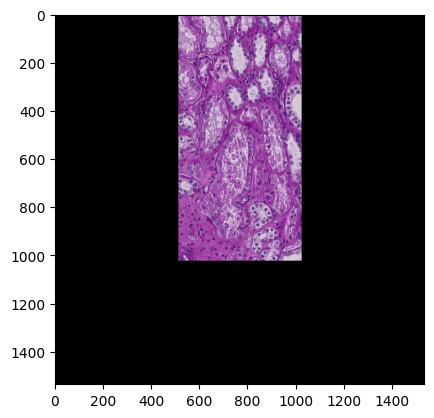

In [168]:
plt.imshow(mosaic)

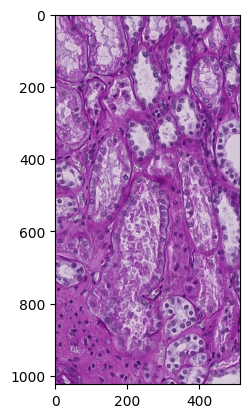

In [157]:
# plt.imshow(np.concatenate([image, sur_img]))
plt.imshow(np.concatenate([sur_img, image]))

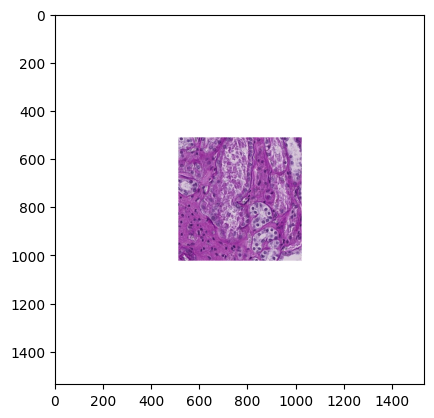

In [107]:
plt.imshow(mosaic)

In [ ]:
mosaic[image_dim:image_dim*2, image_dim:image_dim*2, :] = image

In [ ]:
df[df['i']]

In [ ]:
import cv2
import numpy as np
import pandas as pd

def create_mosaic(image_id, image, df):
    """
    :param image_id: ID of the image to be the center of the mosaic.
    :param image: The image to be the center of the mosaic.
    :param df: Dataframe containing image ids and their coordinates.
    
    :return: Mosaic of images.
    """

    # Find the coordinates of the current image in the dataframe
    image_coordinates = df[df['id'] == image_id][['i', 'j']].values[0]
    
    # Define the surrounding coordinates
    coordinates = [(image_coordinates[0]-1, image_coordinates[1]-1), 
                   (image_coordinates[0]-1, image_coordinates[1]), 
                   (image_coordinates[0]-1, image_coordinates[1]+1),
                   (image_coordinates[0], image_coordinates[1]-1),
                   (image_coordinates[0], image_coordinates[1]+1),
                   (image_coordinates[0]+1, image_coordinates[1]-1),
                   (image_coordinates[0]+1, image_coordinates[1]),
                   (image_coordinates[0]+1, image_coordinates[1]+1)]
    
    # Create an empty list to store the images
    images = []
    
    # Loop over each coordinate and add the image to the list
    for coord in coordinates:
        # Use your function to get the image based on the coordinates
        # This function would likely need to access your image data in some way,
        # so you would need to replace it with your own method.
        surrounding_image_id = df[(df['i'] == coord[0]) & (df['j'] == coord[1])]['id'].values[0]
        surrounding_image = get_image_by_id(surrounding_image_id)
        
        images.append(surrounding_image)
    
    # Add the main image to the center of the list
    images.insert(len(images) // 2, image)
    
    # Concatenate the images horizontally and vertically to form the mosaic
    mosaic = np.concatenate([np.concatenate(images[i:i+3], axis=1) for i in range(0, len(images), 3)], axis=0)
    
    return mosaic


In [41]:
wsi_meta = pd.read_csv("../data/wsi_meta.csv")

In [42]:
wsi_meta

source_wsi  age sex race  height  weight   bmi
0           1   58   F    W   160.0    59.0  23.0
1           2   56   F    W   175.2   139.6  45.5
2           3   73   F    W   162.3    87.5  33.2
3           4   53   M    B   166.0    73.0  26.5

In [56]:
for i in folds_i:
    print(f'fold {i}')
    print(f'IOU mean: {np.mean(folds_iou[i])}')
    print(f'IOU std: {np.std(folds_iou[i])}')


fold 0
IOU mean: 0.5794344903061296
IOU std: 0.022085849802450035
fold 1
IOU mean: 0.5689846116328993
IOU std: 0.020735258531644294
fold 2
IOU mean: 0.5750865659394738
IOU std: 0.018507834813175365
fold 3
IOU mean: 0.5520065558484825
IOU std: 0.03495277978224765
fold 4
IOU mean: 0.569463585907267
IOU std: 0.030832892123935383


In [35]:
for i in folds_i:
    print(f'fold {i}')
    print(f'IOU mean: {np.mean(folds_iou[i])}')
    print(f'IOU std: {np.std(folds_iou[i])}')


fold 0
IOU mean: 0.5813883380571195
IOU std: 0.021602333573493074
fold 1
IOU mean: 0.5718512034934188
IOU std: 0.021204994571685447
fold 2
IOU mean: 0.577511672296694
IOU std: 0.01872297097533825
fold 3
IOU mean: 0.5571941140070192
IOU std: 0.03718892123463371
fold 4
IOU mean: 0.5767471303179905
IOU std: 0.031885737575472674


In [37]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.7, author=tg @ai_minds)
# fold 0
# IOU mean: 0.5813883380571195
# IOU std: 0.021602333573493074
# fold 1
# IOU mean: 0.5718512034934188
# IOU std: 0.021204994571685447
# fold 2
# IOU mean: 0.577511672296694
# IOU std: 0.01872297097533825
# fold 3
# IOU mean: 0.5571941140070192
# IOU std: 0.03718892123463371
# fold 4
# IOU mean: 0.5767471303179905
# IOU std: 0.031885737575472674

In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.5, author=tg @ai_minds)
# fold 0
# IOU mean: 0.5814528026638007
# IOU std: 0.01993106164995504
# fold 1
# IOU mean: 0.5742532196320681
# IOU std: 0.021325379354314125
# fold 2
# IOU mean: 0.5681236433177105
# IOU std: 0.017857128449938295
# fold 3
# IOU mean: 0.5616550087820426
# IOU std: 0.04004046646567095
# fold 4
# IOU mean: 0.581137718008946
# IOU std: 0.02790984538510792

In [ ]:
# fold 0
# IOU mean: 0.5814528026638007
# IOU std: 0.01993106164995504
# fold 1
# IOU mean: 0.5742532196320681
# IOU std: 0.021325379354314125
# fold 2
# IOU mean: 0.5681236433177105
# IOU std: 0.017857128449938295
# fold 3
# IOU mean: 0.5616550087820426
# IOU std: 0.04004046646567095
# fold 4
# IOU mean: 0.581137718008946
# IOU std: 0.02790984538510792

In [ ]:
# NO TTA:
# fold 0 IOU mean: 0.5226953892026813
# fold 0 IOU std: 0.029872814532010492

In [26]:
# WITH TTA:
# fold 0 IOU mean: 0.58
# fold 0 IOU std: 0.019

In [32]:
pred = model(image)[0]


0: 512x512 12 blood_vessels, 11.8ms
Speed: 1.0ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


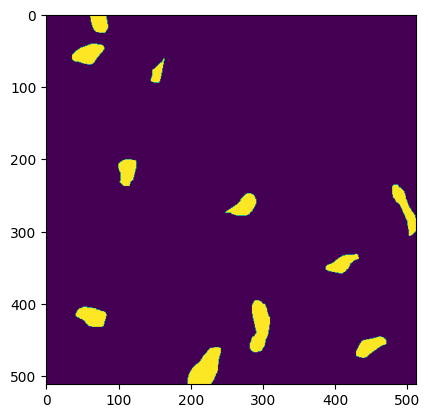

In [61]:
gt_mask = make_masks(ANN_DICT[image_id])
plt.imshow(np.any(gt_mask, axis=0))

In [62]:
tta_boxes, tta_scores, tta_masks, tta_mask_lookup = ensemble_tta(image, [model], CFG, transforms=TRANSFORMS)


0: 512x512 46 blood_vessels, 14.6ms
Speed: 3.5ms preprocess, 14.6ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 48 blood_vessels, 12.8ms
Speed: 1.4ms preprocess, 12.8ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 49 blood_vessels, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 43 blood_vessels, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)


In [111]:
s_pred = predict_yolo(model, np.array(image).astype(np.uint8)[...,::-1], imgsz=CFG.imgsz, conf=CFG.conf, iou_nms=CFG.iou_nms, retina_masks=CFG.retina_masks)


0: 512x512 46 blood_vessels, 13.2ms
Speed: 6.6ms preprocess, 13.2ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 512)


In [113]:
s_pred = predict_yolo(model, image, imgsz=CFG.imgsz, conf=CFG.conf, iou_nms=CFG.iou_nms, retina_masks=CFG.retina_masks)


0: 512x512 46 blood_vessels, 10.6ms
Speed: 1.0ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)


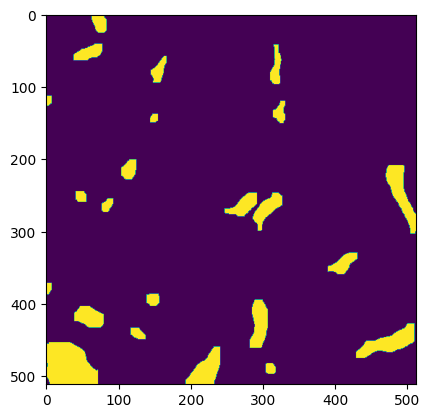

In [64]:
plt.imshow(np.any(s_pred[0]['masks'], 0))

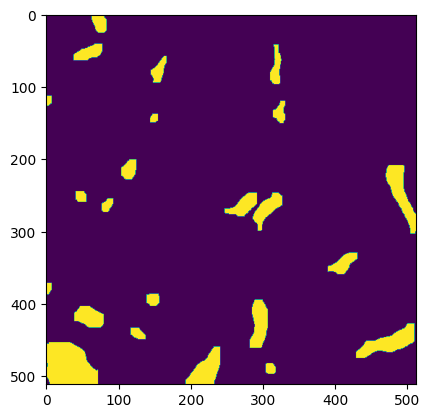

In [66]:
plt.imshow(np.any(tta_masks[0], 0))

In [67]:
from ensemble_boxes import ensemble_boxes_nms, ensemble_boxes_nmw, nms

In [78]:
len(tta_boxes)

4

In [76]:
nms_boxes, nms_scores, nms_labels = nms(tta_boxes,
                            tta_scores,
                            [np.ones(len(b)) for b in tta_boxes], 
                            iou_thr=0.3
                           )

Warning. Fixed 1 boxes coordinates < 0


In [128]:
boxes = [np.concatenate(tta_boxes)]
scores = [np.concatenate(tta_scores)]
labels = [np.ones(len(b)) for b in tta_boxes]
masks = [np.concatenate(tta_masks)]
nms_boxes, nms_scores, nms_labels = nms(
                            boxes,
                            scores,
                            labels, 
                            iou_thr=0.7
                           )

Warning. Fixed 1 boxes coordinates < 0


In [129]:
nms_masks = []
scores_list = scores[0].tolist()
for s in nms_scores:
    nms_masks.append(masks[0][scores_list.index(s)])

In [130]:
len(nms_masks)

77

In [ ]:
np.all()

In [131]:
pred[0]['masks'] = np.stack(nms_masks)
pred[0]['confs'] = np.array(nms_scores)

In [132]:
evaluate_model([parse_ann(ANN_DICT[image_id])], [pred])

[0.8166235937975069]

In [133]:
evaluate_model([parse_ann(ANN_DICT[image_id])], [s_pred])

[0.6717839969361267]

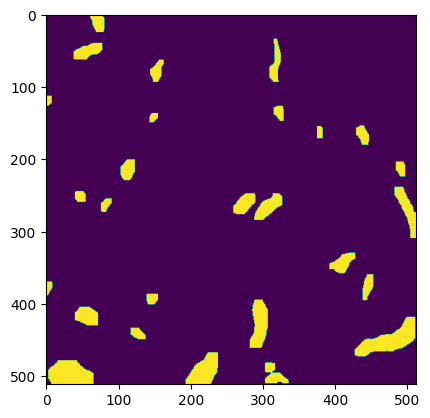

In [103]:
plt.imshow(np.any(np.stack(nms_masks), 0))

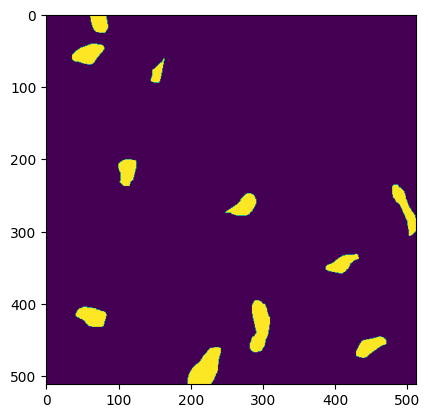

In [105]:
plt.imshow(np.any(gt_mask, 0))

In [114]:
s_pred = predict_yolo(model, image, imgsz=CFG.imgsz, conf=CFG.conf, iou_nms=CFG.iou_nms, retina_masks=CFG.retina_masks)


0: 512x512 46 blood_vessels, 10.8ms
Speed: 1.0ms preprocess, 10.8ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)


In [87]:
thres=0.1

In [88]:
labels = []
for i in range(len(boxes)):
    labels.append(np.ones(len(boxes[i]), dtype=np.uint8))

In [112]:
wbf_boxes, wbf_scores, _, wbf_originals = weighted_boxes_fusion_tracking(boxes, 
                                                                         box_scores, 
                                                                         labels_list=labels, 
                                                                         iou_thr=0.1, 
                                                                         skip_box_thr=0.01)

In [155]:
boxes, box_scores, tta_masks, tta_masks_lkup = TTA(image, [model], CFG, aug_list=AUGMENTATIONS)
wbf_boxes, wbf_scores, _, wbf_originals = weighted_boxes_fusion_tracking(boxes, 
                                                                         box_scores, 
                                                                         labels_list=labels, 
                                                                         iou_thr=0.1, 
                                                                         skip_box_thr=0.1)

tta_masks_list = []
for i in range(len(wbf_boxes)):
    mask = get_wsf_mask(wbf_boxes[i], wbf_originals[i], tta_masks, tta_masks_lkup, thres=0.6)
    tta_masks_list.append(mask)
tta_masks = np.stack(tta_masks_list)
pred[0]['masks'] = tta_masks
pred[0]['confs'] = wbf_scores
tta_masks.shape


0: 512x512 46 blood_vessels, 11.5ms
Speed: 5.2ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 48 blood_vessels, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 49 blood_vessels, 10.5ms
Speed: 1.1ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 43 blood_vessels, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


(16, 512, 512)

In [116]:
evaluate_model([parse_ann(ANN_DICT[image_id])], [s_pred])

[0.6717839969361267]

In [115]:
evaluate_model([parse_ann(ANN_DICT[image_id])], [pred])

[0.7921122994652408]

In [146]:
gt_mask = make_masks(ANN_DICT[image_id])

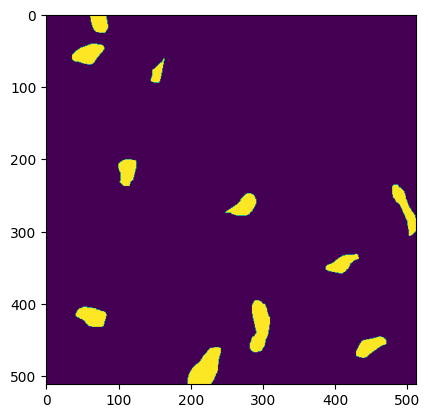

In [147]:
plt.imshow(np.any(gt_mask, axis=0))

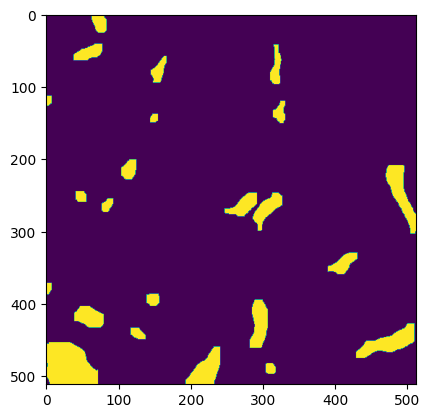

In [140]:
plt.imshow(np.any(s_pred[0]['masks'], axis=0))

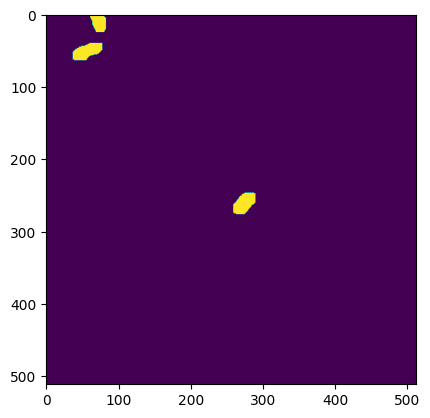

In [152]:
plt.imshow(np.any(pred[0]['masks'], axis=0))

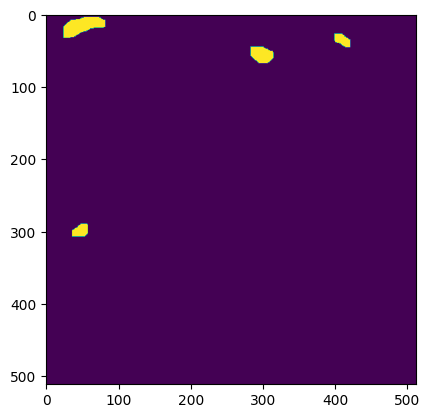

In [179]:
plt.imshow(np.any(pred[0]['masks'], axis=0))

In [50]:
pred

([array([[    0.42855,     0.21127,     0.48399,     0.28798,     0.72304,           0],
         [    0.16589,     0.74756,     0.19777,     0.79543,     0.69357,           0],
         [   0.058156,     0.97245,     0.10065,     0.99984,     0.59243,           0],
         [    0.25406,     0.56544,     0.31265,     0.65945,     0.50261,           0],
         [     0.6346,     0.72618,     0.72726,     0.85246,     0.47771,           0],
         [    0.20442,     0.91025,     0.29782,     0.96996,     0.46474,           0],
         [    0.57774,     0.66465,      0.6298,     0.75509,     0.29946,           0],
         [    0.25363,     0.56375,     0.31191,     0.70784,     0.29707,           0],
         [    0.06145,     0.65069,     0.09948,      0.7237,     0.23071,           0],
         [     0.2589,     0.15411,     0.34518,     0.25293,     0.16042,           0],
         [    0.88144,     0.56573,     0.90786,     0.60929,     0.15778,           0],
         [    0.52972

In [25]:
# folds_i = [0, 1, 2, 3, 4]
folds_i = [0, 1, 2, 3, 4]



folds_iou = dict()
for i in folds_i:
    path_to_data = f'{FOLDS_ROOT}/fold{i}/hubmap-coco.yaml'

    
    model = YOLO(f'{PROJECT}/{MODEL_V}-fold{i}/weights/best.pt')
    
    
    val_dir = f'{FOLDS_ROOT}/fold{i}/valid/'
    val_ids = [r.split('.')[0] for r in os.listdir(val_dir) if r.endswith('.txt')]
    annotations = [parse_ann(ANN_DICT[image_id]) for image_id in val_ids]
    images = [Image.open(os.path.join(val_dir ,image_id+'.tif')) for image_id in val_ids]
    
    predictions = []
    for image in images:
        pred = predict_yolo(model, image, imgsz=CFG.imgsz, conf=CFG.conf, iou_nms=CFG.iou_nms, retina_masks=CFG.retina_masks)
        pred[0]['masks'] = dilate_predict_mask(pred[0]['masks'], CFG.dilation_n_iter)
        predictions.append(pred)
    
    ious = evaluate_model(annotations, predictions)
    print(f'fold {i} IOU mean: {np.mean(ious)}')
    print(f'fold {i} IOU std: {np.std(ious)}')
    
    folds_iou[i] = ious


0: 512x512 46 blood_vessels, 11.8ms
Speed: 3.5ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 54 blood_vessels, 13.1ms
Speed: 1.5ms preprocess, 13.1ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 49 blood_vessels, 12.5ms
Speed: 1.1ms preprocess, 12.5ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 19 blood_vessels, 5 unsures, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 26 blood_vessels, 11.9ms
Speed: 1.0ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 38 blood_vessels, 3 glomeruluss, 12.4ms
Speed: 0.9ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 73 blood_vessels, 1 glomerulus, 13.9ms
Speed: 1.6ms preprocess, 13.9ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 63 blood_v


0: 512x512 52 blood_vessels, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 69 blood_vessels, 1 glomerulus, 3 unsures, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 64 blood_vessels, 1 glomerulus, 12.7ms
Speed: 1.2ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 83 blood_vessels, 11.8ms
Speed: 1.0ms preprocess, 11.8ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 36 blood_vessels, 12.1ms
Speed: 1.0ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 54 blood_vessels, 14 unsures, 12.2ms
Speed: 1.0ms preprocess, 12.2ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 19 blood_vessels, 15 unsures, 12.1ms
Speed: 1.0ms preprocess, 12.1ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)


0: 512x512 52 blood_vessels, 13.2ms
Speed: 1.1ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 47 blood_vessels, 12.4ms
Speed: 1.4ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 27 blood_vessels, 1 glomerulus, 13.6ms
Speed: 1.1ms preprocess, 13.6ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 49 blood_vessels, 2 unsures, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 25 blood_vessels, 11.4ms
Speed: 1.0ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 103 blood_vessels, 4 glomeruluss, 1 unsure, 13.5ms
Speed: 1.4ms preprocess, 13.5ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 46 blood_vessels, 1 glomerulus, 1 unsure, 13.5ms
Speed: 1.6ms preprocess, 13.5ms inference, 1.9ms postprocess per image at shape (1, 

Speed: 1.1ms preprocess, 13.0ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 28 blood_vessels, 11.3ms
Speed: 0.9ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 35 blood_vessels, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 27 blood_vessels, 4 unsures, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 25 blood_vessels, 12.5ms
Speed: 2.7ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 88 blood_vessels, 3 unsures, 13.6ms
Speed: 0.9ms preprocess, 13.6ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 25 blood_vessels, 12.7ms
Speed: 1.2ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 13 blood_vessels, 1 unsure, 14.9ms
Speed: 1.0ms preprocess, 14.9m


0: 512x512 66 blood_vessels, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 7 blood_vessels, 12.6ms
Speed: 1.4ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 55 blood_vessels, 1 glomerulus, 12.4ms
Speed: 1.1ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 36 blood_vessels, 7 unsures, 12.0ms
Speed: 1.1ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 84 blood_vessels, 13.4ms
Speed: 0.9ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 67 blood_vessels, 13.8ms
Speed: 1.0ms preprocess, 13.8ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 107 blood_vessels, 12.6ms
Speed: 1.1ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 52 blood_vessels, 4 unsur

Speed: 1.1ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 79 blood_vessels, 1 unsure, 13.5ms
Speed: 1.1ms preprocess, 13.5ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 29 blood_vessels, 7 unsures, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 35 blood_vessels, 4 glomeruluss, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 19 blood_vessels, 13 unsures, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 11 blood_vessels, 8 unsures, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 36 blood_vessels, 1 glomerulus, 12.9ms
Speed: 1.1ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 40 blood_vesse

fold 0 IOU mean: 0.5226775615656347
fold 0 IOU std: 0.0298696138917803



0: 512x512 65 blood_vessels, 12.6ms
Speed: 1.4ms preprocess, 12.6ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 9 blood_vessels, 3 unsures, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 51 blood_vessels, 13.1ms
Speed: 1.2ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 51 blood_vessels, 12.4ms
Speed: 1.1ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 70 blood_vessels, 13.9ms
Speed: 1.0ms preprocess, 13.9ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 70 blood_vessels, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 26 blood_vessels, 11.6ms
Speed: 1.0ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 93 blood_vessels, 15.4ms
Speed: 1.0ms pr


0: 512x512 25 blood_vessels, 14.4ms
Speed: 1.0ms preprocess, 14.4ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 58 blood_vessels, 13.6ms
Speed: 1.0ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 52 blood_vessels, 12.7ms
Speed: 1.1ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 32 blood_vessels, 3 glomeruluss, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 53 blood_vessels, 1 glomerulus, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 51 blood_vessels, 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 59 blood_vessels, 1 glomerulus, 11.3ms
Speed: 1.0ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 4 blood

Speed: 1.0ms preprocess, 13.1ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 66 blood_vessels, 13.6ms
Speed: 1.0ms preprocess, 13.6ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 64 blood_vessels, 2 glomeruluss, 13.5ms
Speed: 1.0ms preprocess, 13.5ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 48 blood_vessels, 12.3ms
Speed: 1.1ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 65 blood_vessels, 1 glomerulus, 13.1ms
Speed: 1.0ms preprocess, 13.1ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 85 blood_vessels, 2 unsures, 13.3ms
Speed: 1.2ms preprocess, 13.3ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 18 blood_vessels, 19 unsures, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 49 blood_vessels, 13.4ms
Speed: 1.0


0: 512x512 59 blood_vessels, 1 glomerulus, 14.1ms
Speed: 1.1ms preprocess, 14.1ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 73 blood_vessels, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 19 blood_vessels, 13 unsures, 13.7ms
Speed: 1.1ms preprocess, 13.7ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 68 blood_vessels, 1 glomerulus, 13.1ms
Speed: 1.6ms preprocess, 13.1ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 41 blood_vessels, 3 glomeruluss, 13.9ms
Speed: 1.2ms preprocess, 13.9ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 32 blood_vessels, 22 unsures, 14.1ms
Speed: 1.2ms preprocess, 14.1ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 89 blood_vessels, 1 glomerulus, 11.9ms
Speed: 1.1ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shap

Speed: 1.2ms preprocess, 14.0ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 53 blood_vessels, 3 glomeruluss, 11.8ms
Speed: 1.0ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 66 blood_vessels, 13.3ms
Speed: 1.0ms preprocess, 13.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 115 blood_vessels, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 35 blood_vessels, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 113 blood_vessels, 1 glomerulus, 1 unsure, 13.3ms
Speed: 1.1ms preprocess, 13.3ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 56 blood_vessels, 13.1ms
Speed: 1.1ms preprocess, 13.1ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 61 blood_vessels, 1 glomerulus, 5 unsures, 11.


0: 512x512 20 blood_vessels, 13 unsures, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 56 blood_vessels, 6 unsures, 13.4ms
Speed: 1.3ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 68 blood_vessels, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 67 blood_vessels, 12.2ms
Speed: 1.5ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 94 blood_vessels, 1 unsure, 11.5ms
Speed: 2.6ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 56 blood_vessels, 5 glomeruluss, 13.5ms
Speed: 1.6ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 36 blood_vessels, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 51

fold 1 IOU mean: 0.505400724742647
fold 1 IOU std: 0.02662789144879158


In [27]:
folds_i = [0, 1, 2, 3, 4]

In [28]:
for i in folds_i:
    print(f'fold {i}')
    print(f'IOU mean: {np.mean(folds_iou[i])}')
    print(f'IOU std: {np.std(folds_iou[i])}')
    

fold 0
IOU mean: 0.5226775615656347
IOU std: 0.0298696138917803
fold 1
IOU mean: 0.505400724742647
IOU std: 0.02662789144879158
fold 2
IOU mean: 0.4994595288644123
IOU std: 0.0262324552179582
fold 3
IOU mean: 0.4639506381049814
IOU std: 0.03842500682632922
fold 4
IOU mean: 0.49289279544080083
IOU std: 0.027926462323214524


In [39]:
print('overall')
print(f'IOU mean: {np.mean(sum(folds_iou.values(), []))}')
print(f'IOU std: {np.std(sum(folds_iou.values(), []))}')

overall
IOU mean: 0.4970024383809635
IOU std: 0.035671124373651455


In [ ]:
#     mosaic=True: Аугментация изображений с помощью объединения нескольких изображений в одно (mosaic augmentation).
#     mixup=0.5: Случайное смешивание изображений для создания новых изображений (mixup augmentation).
#     random_placing=True: Случайное размещение объектов на изображении (random object placing augmentation).
#     hsv_augmentation=True: Изменение цветового пространства изображений (HSV augmentation).
#     degrees=10.0: Вращение изображений на случайный угол (rotation augmentation).
#     translate=0.1: Случайное смещение изображений по горизонтали и вертикали (translation augmentation).
#     scale=0.5: Масштабирование изображений на случайный коэффициент (scale augmentation).
#     shear=2.0: Наклон изображений на случайный угол (shear augmentation).
#     perspective=0.0: Изменение перспективы изображений (perspective augmentation).
#     flipud=0.5: Отражение изображений по вертикали (vertical flip augmentation).
#     fliplr=0.5: Отражение изображений по горизонтали (horizontal flip augmentation).
#     mosaic_scale=[0.5, 1.5]: Масштабирование мозаики изображений на случайный коэффициент.

# INFERENCE

In [9]:
model = YOLO('HuBMAP/yolov8x-seg10/weights/best.pt')

In [10]:
DATA_BASE = 'dataset'
BASE_FILENAME = '../data/'

In [12]:
from skimage.morphology import binary_dilation, binary_closing, binary_opening
from skimage.measure import label, regionprops

def join_masks(masks: np.ndarray):
    """masks in shape n x W x H """
    return np.any(masks, axis=0).astype(int)

def substact_masks(mask1, mask2):
    substraction = mask1 & ~mask2
    if len(substraction) == 0:
        return np.zeros_like(mask1)
    return substraction

def disjoin_mask(mask):
    """mask in shape W x H"""
    if not np.any(mask):
        return mask[None, :, :]
    labeled_mask = label(mask)  # Результат - маска, где каждый объект имеет уникальное число
    props = regionprops(labeled_mask)

    new_masks = []
    for prop in props:
        new_mask = np.zeros_like(mask)
        new_mask[labeled_mask == prop.label] = 1
        new_masks.append(new_mask)

    new_masks_array = np.array(new_masks)
    return new_masks_array

def dilate_predict_mask(mask, n_iter=1):
    for i in range(len(mask)):
        for _ in range(n_iter):
            mask[i] = binary_dilation(mask[i])
    return mask

In [13]:
val_dir = f"{DATA_BASE}/val"
val_ids = [r.split('.')[0] for r in os.listdir(val_dir+'/labels')]

In [14]:
with open(f'{BASE_FILENAME}/polygons.jsonl', 'r') as json_file:
    json_labels = [json.loads(line) for line in json_file]

In [15]:
ann_dict = {j['id']: j['annotations'] for j in json_labels}

In [16]:
# def fine_tune(mask_sam, mask_data, iou_thresh=0.4):
#     for i in range(mask_sam.shape[0]):
#         for j in range(mask_data.shape[0]):
#             intersection = np.count_nonzero(mask_sam[i,:,:] & mask_data[j,:,:])
#             if intersection == 0:
#                 continue
#             union = np.count_nonzero(mask_sam[i,:,:] | mask_data[j,:,:])
            
#             iou = intersection / union
            
#             if iou > iou_thresh:
#                 mask_data[j,:,:] = mask_sam[i,:,:] | mask_data[j,:,:]
#                 break
#     return mask_data

In [19]:
from skimage.morphology import binary_dilation, binary_closing, binary_opening

def dilate_predict_mask(mask, n_iter=1):
    for i in range(len(mask)):
        for _ in range(n_iter):
            mask[i] = binary_dilation(mask[i])
    return mask

In [20]:
import cv2

def dilate_predict_mask_cv(mask, n_iter=1):
    kernel = np.ones(shape=(3, 3), dtype=np.uint8)
    for i in range(len(mask)):
        mask[i] = cv2.dilate(mask[i].astype(np.uint8), kernel, 1, iterations=n_iter)
    return mask

In [22]:
import torch
from segmentation_models_pytorch.metrics.functional import iou_score, get_stats, f1_score, recall, precision

In [23]:
from ultralytics import SAM
# sam = SAM()

In [24]:
image_id = val_ids[0]

In [25]:
image = Image.open(os.path.join(val_dir, 'images' ,image_id+'.tif'))
height, width = image.size

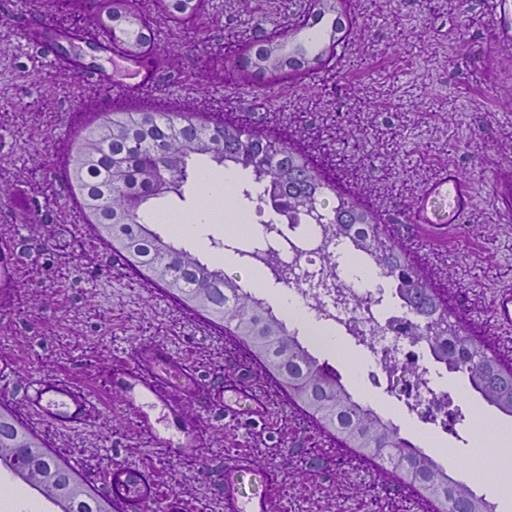

In [26]:
image

In [27]:
pred = predict_yolo(model, image, imgsz=640)


0: 640x640 17 blood_vessels, 4 unsures, 14.2ms
Speed: 17.0ms preprocess, 14.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


In [28]:
ann = parse_ann(ann_dict[image_id])

In [29]:
mAP_calc = MAPCalculatorSingleClass()

In [30]:
enc_gt = coco_mask.frPyObjects(ann, height, width)
num_gts = len(enc_gt)

In [31]:
pred_masks = pred[0]['masks'].astype(np.uint8)
scores = pred[0]['confs']
enc_pred = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]

In [32]:
ious = mask_util.iou(enc_pred, enc_gt, [0]*len(enc_gt))

In [44]:
mAP_calc.accumulate(ious, scores, num_gts)

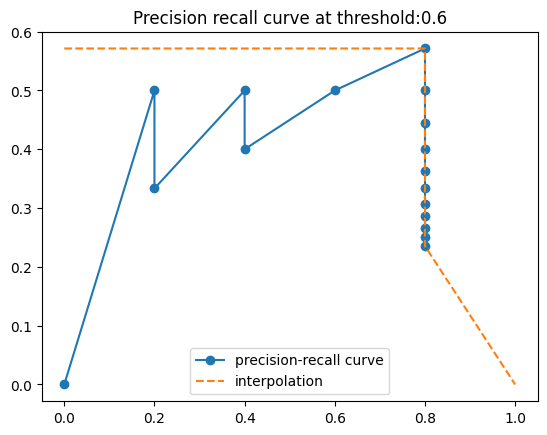

(0.45714285714285713, {0.6: 0.45714285714285713})

In [45]:
mAP_calc.evaluate(vis=1)

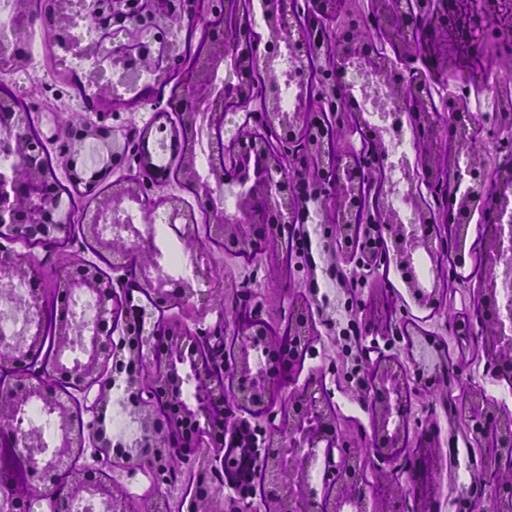

In [287]:
image

In [79]:
import base64
import numpy as np
import torch
from pycocotools import _mask as coco_mask
import typing as t
import zlib
import pandas as pd
import torchvision.transforms as T
from ultralytics import YOLO
from PIL import Image

In [57]:
class EncodeBinaryMask:
    @staticmethod
    def __checking_mask(mask: np.ndarray) -> np.ndarray:
        if mask.dtype != bool:
            raise ValueError(
                "expects a binary mask, received dtype == %s" %
                mask.dtype
            )
        return mask

    @staticmethod
    def __convert_mask(mask: np.ndarray):
        mask_to_encode = mask.astype(np.uint8)
        mask_to_encode = np.asfortranarray(mask_to_encode)
        return mask_to_encode

    @staticmethod
    def __compress_encode(encoded_mask) -> t.Text:
        binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
        base64_str = base64.b64encode(binary_str)
        return base64_str

    def __call__(self, mask: np.ndarray) -> t.Text:
        mask = self.__checking_mask(mask)
        mask_to_encode = self.__convert_mask(mask)
        encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]
        base64_str = self.__compress_encode(encoded_mask)
        return base64_str